In [1]:
import pandas as pd   
import requests      
from bs4 import BeautifulSoup 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets 
from ast import literal_eval
from tabulate import tabulate
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
drive.mount('/content/drive')

Mounted at /content/drive


# Crawler

In [ ]:
movie_name = []
year = []
time = []
rating = []
metascore = []
votes = []
gross = []
genres = []
description = []
Director = []
Stars = []

for j in range(1990,2023,1):
	for i in range(1,9902,100):
		url = 'https://www.imdb.com/search/title/?title_type=feature&year='+str(j)+','+str(j)+'&num_votes=1,&count=100&start='+str(i)+'&ref_=adv_nxt'
		response = requests.get(url)
		soup = BeautifulSoup(response.content, 'html.parser')
		movie_data = soup.findAll('div', attrs= {'class': 'lister-item mode-advanced'})
		if movie_data == []:
			break
		for store in movie_data:
				# Name		
				name = store.h3.a.text
				movie_name.append(name)
		
				# Year
				year_of_release = store.h3.find('span', class_ = 'lister-item-year text-muted unbold').text.replace('(', '').replace(')', '').strip()
				year.append(year_of_release)
		
				# Runtime
				if store.p.find('span', class_ = 'runtime') is None:
					runtime = None
				else: runtime = store.p.find('span', class_ = 'runtime').text.replace(' min', '')
				time.append(runtime)
				
				# Rating
				rate = store.find('div', class_ = 'inline-block ratings-imdb-rating').text.replace('\n', '')
				rating.append(rate)
				try:
					genre = store.p.find('span', class_ = 'genre').text.strip()
				except: 
					genre = None
				genres.append(genre)
				meta  = store.find('span', class_ = 'metascore').text.replace(' ', '') if store.find('span', class_ = 'metascore') else None
				metascore.append(meta)
		
				#Votes and Gross
				value = store.find_all('span', attrs = {'name': 'nv'})
				
				if value == []:
					votes.append(None)
				else:
					vote = value[0].text
					votes.append(vote)
				
				grosses = value[1].text if len(value) >1 else None
				gross.append(grosses)
				
				# Description of the Movies
				describe = store.find_all('p', class_ = 'text-muted')
				description_ = describe[1].text.replace('\n', '')
				if description_ == 'Add a Plot':
					description_ = None
				description.append(description_)
				
				#Cast Details
				try:
					cast = store.findAll("p", class_ = "")[1]
					cast = cast.text.replace('\n', '').split('|')
					cast = [x.strip() for x in cast]
					cast[0] = cast[0].replace("Directors:","").replace("Director:","")
			
					if len(cast) > 1: 
						cast[1] = cast[1].replace("Stars:","")
					else: 
						cast.append('')
				
					if cast[0] == '':
						cast[0] = None	
					Director.append(cast[0])
			
					if cast[1] == '':
						cast[1] = None
						Stars.append(cast[1])
					else:
						Stars.append([x.strip() for x in cast[1].split(",")])
				except: 
					Director.append(None)
					Stars.append(None)
    
movie_DF = pd.DataFrame({'Name': movie_name, 'Year': year,'Genre': genres ,'Runtime': time, 'Rating': rating, 'Metascore': metascore, 'Votes': votes, 'Gross': gross, 'Description': description, "Director": Director, 'Stars': Stars})


In [ ]:
movie_DF.head(5)
movie_DF.info()

In [ ]:
movie_DF.to_csv('/content/drive/MyDrive/IMDB_Data/raw.csv')

# Cleaning

In [7]:
df = pd.read_csv('/content/drive/MyDrive/IMDB_Data/raw.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237860 entries, 0 to 237859
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         237860 non-null  object 
 1   Year         237834 non-null  object 
 2   Genre        228038 non-null  object 
 3   Runtime      213980 non-null  object 
 4   Rating       237860 non-null  float64
 5   Metascore    15837 non-null   float64
 6   Votes        237859 non-null  object 
 7   Gross        15453 non-null   object 
 8   Description  200818 non-null  object 
 9   Director     237302 non-null  object 
 10  Stars        233877 non-null  object 
dtypes: float64(2), object(9)
memory usage: 20.0+ MB


In [5]:
df.isna().any()

Name           False
Year            True
Genre           True
Runtime         True
Rating         False
Metascore       True
Votes           True
Gross           True
Description     True
Director        True
Stars           True
dtype: bool

In [ ]:
number_missing = df.isnull().sum()
percent_missing = number_missing * 100 / len(df)
missing_value_df = pd.DataFrame({'number_missing': number_missing,'percent_missing': percent_missing})

In [ ]:
missing_value_df

,number_missing,percent_missing
Name,0,0.000000
Year,26,0.010931
Genre,9822,4.129320
Runtime,23880,10.039519
Rating,0,0.000000
Metascore,222023,93.341882
Votes,1,0.000420
Gross,222407,93.503321
Description,37042,15.573026
Director,558,0.234592


In [10]:
df1 = df.dropna()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10303 entries, 658 to 225783
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         10303 non-null  object 
 1   Year         10303 non-null  object 
 2   Genre        10303 non-null  object 
 3   Runtime      10303 non-null  object 
 4   Rating       10303 non-null  float64
 5   Metascore    10303 non-null  float64
 6   Votes        10303 non-null  object 
 7   Gross        10303 non-null  object 
 8   Description  10303 non-null  object 
 9   Director     10303 non-null  object 
 10  Stars        10303 non-null  object 
dtypes: float64(2), object(9)
memory usage: 965.9+ KB


In [ ]:
df1.Gross

658        $2.18M
3123       $0.05M
3914       $1.24M
3915       $0.54M
3917       $7.63M
           ...   
225195    $34.54M
225281    $40.50M
225295     $0.02M
225495     $0.39M
225783     $0.06M
Name: Gross, Length: 10303, dtype: object

In [ ]:
Gross = []
for grosst in df1['Gross']:
  try:
    grosst =  int(float(grosst.replace("$","").replace("M",""))*(10**6))
    Gross.append(grosst)
  except:
    Gross.append(0)
    pass
df1['Gross'] = Gross
print(df1['Gross'])

658        2180000
3123         50000
3914       1240000
3915        540000
3917       7630000
            ...   
225195    34540000
225281    40500000
225295       20000
225495      390000
225783       60000
Name: Gross, Length: 10303, dtype: int64


<ipython-input-405-4d48d7dd8dc2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Gross'] = Gross


In [ ]:
df1.Votes

658        15,880
3123       58,731
3914      176,257
3915       51,745
3917       10,322
           ...   
225195     20,710
225281     12,222
225295      1,820
225495      5,018
225783        248
Name: Votes, Length: 10303, dtype: object

In [ ]:
popularity = []
for vote in df1['Votes']:
  try:
    vote =  int(vote.replace(",",""))
    popularity.append(vote)
  except:
    popularity.append(0)
    pass
df1['Votes'] = popularity
print(df1['Votes'])

658        15880
3123       58731
3914      176257
3915       51745
3917       10322
           ...  
225195     20710
225281     12222
225295      1820
225495      5018
225783       248
Name: Votes, Length: 10303, dtype: int64


<ipython-input-407-6655746bba94>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Votes'] = popularity


In [11]:
year   = []
for years in df1['Year']:
  try:
    years = int(years.replace("I","").replace("X","").replace("V","").strip())
    year.append(years)
  except:
    year.append(0)
df1['Year']=year
print(df1['Year'])

0         1903
1         1905
2         1905
3         1905
4         1905
          ... 
237855    2022
237856    2022
237857    2022
237858    2022
237859    2022
Name: Year, Length: 237860, dtype: int64


In [ ]:
df1.describe()

In [ ]:
df2 = df1[df1['Votes'] >= 10000]

In [ ]:
df2 = df2.reset_index(drop=True)

In [ ]:
df2.sort_values(by=['Rating'])

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
5570,Kirk Cameron's Saving Christmas,2014,"Comedy, Family",79,1.3,18.0,16202,2780000,His annual Christmas party faltering thanks to...,Darren Doane,"['Kirk Cameron', 'Darren Doane', 'Bridgette Ca..."
3170,Superbabies: Baby Geniuses 2,2004,"Comedy, Family, Sci-Fi",88,1.5,9.0,31193,9110000,A group of smart-talking toddlers find themsel...,Bob Clark,"['Jon Voight', 'Scott Baio', 'Vanessa Angel', ..."
5072,The Oogieloves in the Big Balloon Adventure,2012,"Adventure, Family, Fantasy",88,1.7,32.0,15397,1060000,"The Oogieloves, Goobie, Zoozie, and Toofie, se...",Matthew Diamond,"['Jaime Pressly', 'Cloris Leachman', 'Christop..."
4047,The Hottie & the Nottie,2008,"Comedy, Romance",91,1.9,7.0,38483,30000,A woman agrees to go on a date with a man only...,Tom Putnam,"['Paris Hilton', 'Joel David Moore', 'Christin..."
2973,From Justin to Kelly,2003,"Comedy, Musical, Romance",81,1.9,14.0,26550,4920000,A waitress from Texas and a college student fr...,Robert Iscove,"['Kelly Clarkson', 'Justin Guarini', 'Katherin..."
...,...,...,...,...,...,...,...,...,...,...,...
3928,The Dark Knight,2008,"Action, Crime, Drama",152,9.0,84.0,2667150,534860000,When the menace known as the Joker wreaks havo...,Christopher Nolan,"['Christian Bale', 'Heath Ledger', 'Aaron Eckh..."
92,12 Angry Men,1957,"Crime, Drama",96,9.0,96.0,795781,4360000,The jury in a New York City murder trial is fr...,Sidney Lumet,"['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam'..."
1425,Schindler's List,1993,"Biography, Drama, History",195,9.0,94.0,1362183,96900000,"In German-occupied Poland during World War II,...",Steven Spielberg,"['Liam Neeson', 'Ralph Fiennes', 'Ben Kingsley..."
273,The Godfather,1972,"Crime, Drama",175,9.2,100.0,1868917,134970000,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan', '..."


In [ ]:
df2 = df2.reset_index(drop=True)

In [ ]:
df2.to_csv('/content/drive/MyDrive/IMDB_Data/cleaned.csv')

# Preprocess

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IMDB_Data/cleaned.csv',index_col=0)
data

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,"Drama, History",197,7.7,99.0,15880,2180000,The story of a poor young woman separated by p...,D.W. Griffith,"['Lillian Gish', 'Robert Harron', 'Mae Marsh',..."
1,Battleship Potemkin,1925,"Drama, History, Thriller",66,7.9,97.0,58731,50000,In the midst of the Russian Revolution of 1905...,Sergei Eisenstein,"['Aleksandr Antonov', 'Vladimir Barskiy', 'Gri..."
2,Metropolis,1927,"Drama, Sci-Fi",153,8.3,98.0,176257,1240000,In a futuristic city sharply divided between t...,Fritz Lang,"['Brigitte Helm', 'Alfred Abel', 'Gustav Fröhl..."
3,Sunrise,1927,"Drama, Romance",94,8.1,95.0,51745,540000,A sophisticated urban woman seduces a farmer i...,F.W. Murnau,"[""George O'Brien"", 'Janet Gaynor', 'Margaret L..."
4,The Jazz Singer,1927,"Drama, Music, Musical",88,6.4,66.0,10322,7630000,The son of a Jewish Cantor must defy the tradi...,Alan Crosland,"['Al Jolson', 'May McAvoy', 'Warner Oland', 'E..."
...,...,...,...,...,...,...,...,...,...,...,...
6644,Space Jam: A New Legacy,2021,"Animation, Adventure, Comedy",115,4.5,36.0,73236,70590000,A rogue artificial intelligence kidnaps the so...,Malcolm D. Lee,"['LeBron James', 'Don Cheadle', 'Cedric Joe', ..."
6645,The Forever Purge,2021,"Action, Crime, Horror",103,5.4,53.0,35443,44540000,All the rules are broken as a sect of lawless ...,Everardo Gout,"['Ana de la Reguera', 'Tenoch Huerta', 'Josh L..."
6646,The Boss Baby: Family Business,2021,"Animation, Adventure, Comedy",107,5.9,39.0,19126,57300000,The Templeton brothers have become adults and ...,Tom McGrath,"['Alec Baldwin', 'James Marsden', 'Amy Sedaris..."
6647,Jujutsu Kaisen 0: The Movie,2021,"Animation, Action, Fantasy",112,7.8,71.0,20710,34540000,"Yuta Okkotsu, a high schooler who gains contro...",Seong-Hu Park,"['Chinatsu Akasaki', 'Aya Endô', 'Kana Hanazaw..."


In [ ]:
df_ = data

In [ ]:
genre_dict = {}
for genre in df_['Genre']:
  try:
    gen = [x.strip() for x in genre.split(",")]
    for _ in gen:
      genre_dict[_] = genre_dict.get(_,0)+1
  except:
    pass
genre_dict = {x : y for x,y in sorted(genre_dict.items(), key = lambda x : x[1], reverse=True)}
print(genre_dict)
genre_list = list(genre_dict.keys())

{'Drama': 3663, 'Comedy': 2565, 'Action': 1639, 'Crime': 1318, 'Adventure': 1276, 'Romance': 1181, 'Thriller': 1072, 'Horror': 742, 'Mystery': 630, 'Fantasy': 541, 'Sci-Fi': 507, 'Biography': 490, 'Family': 356, 'Animation': 338, 'Music': 215, 'History': 205, 'Sport': 157, 'War': 134, 'Musical': 76, 'Western': 72, 'Film-Noir': 13}


In [ ]:
def caculateScore(data, columnName):
    names = data[['Rating', columnName]]
    my_dict = {}
    n = len(names)
    for i in range(n):
        avgR, name = names.iloc[i,:]    
        for s in name:
            if s not in my_dict.keys():
                my_dict[s] = [avgR, 1]
            else:
                a = my_dict[s]
                a = [avgR + a[0], a[1] + 1]
                my_dict[s] = a
    for a in my_dict:
        score, n = my_dict[a]
        my_dict[a] = score/n
    return my_dict

def tfidf(x):
    s_w = ['is', 'are', 'they', 'them', 'him', 'if', 'so', 'an', 'and', 'as', 'by', \
           'for', 'he', 'her', 'his', 'in', 'is', 'of', 'on', 'she', 'that', 'the', 'their', 'they', 'to', 'who', 'with',\
          'him', 'i',
            'me',
            'my',
            'myself',
            'we',
            'our',
            'ours',
            'ourselves',
            'you',
            'your',
            'yours',
            'yourself',
            'yourselves',
            'he',
            'him',
            'his',
            'himself',
            'she',
            'her',
            'hers',
            'herself',
            'it',
            'its',
            'itself',
            'they',
            'them',
            'their',
            'theirs',
            'themselves',
            'what',
            'which',
            'who',
            'whom',
            'this',
            'that',
            'these',
            'those',
            'am',
            'is',
            'are',
            'was',
            'were',
            'be',
            'been',
            'being',
            'have',
            'has',
            'had',
            'having',
            'do',
            'does',
            'did',
            'doing',
            'a',
            'an',
            'the',
            'and',
            'but',
            'if',
            'or',
            'because',
            'as',
            'until',
            'while',
            'of',
            'at',
            'by',
            'for',
            'with',
            'about',
            'against',
            'between',
            'into',
            'through',
            'during',
            'before',
            'after',
            'above',
            'below',
            'to',
            'from',
            'up',
            'down',
            'in',
            'out',
            'on',
            'off',
            'over',
            'under',
            'again',
            'further',
            'then',
            'once',
            'here',
            'there',
            'when',
            'where',
            'why',
            'how',
            'all',
            'any',
            'both',
            'each',
            'few',
            'more',
            'most',
            'other',
            'some',
            'such',
            'no',
            'nor',
            'not',
            'only',
            'own',
            'same',
            'so',
            'than',
            'too',
            'very',
            's',
            't',
            'can',
            'will',
            'just',
            'don',
            'should',
            'now']
    vectorizer = TfidfVectorizer(max_features=5,stop_words=s_w)
    vectorizer.fit_transform(x)
    return vectorizer.get_feature_names()

def scoring(l):
    global d
    n = len(l)
    s = 0
    for ele in l:
        try:
            s += d[ele] 
        except:
            pass
    return s/n

In [ ]:
#convert Description
data['Description'] = data['Description'].apply(lambda x: tfidf([x]))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
data['Description']

0       [baby, history, husband, interwoven, intolerance]
1          [1905, resulting, revolution, russian, street]
2             [city, class, coming, differences, working]
3                   [city, discovers, ends, farmer, wife]
4                 [becoming, cantor, defy, dream, father]
                              ...                        
6644         [artificial, basketball, bugs, bunny, famed]
6645             [annual, broken, daybreak, decides, end]
6646                 [adults, edge, family, inspire, new]
6647          [control, high, jujutsu, sorcerers, spirit]
6648                  [bea, family, peter, rabbit, shady]
Name: Description, Length: 6649, dtype: object

In [ ]:
sl_map = caculateScore(data,'Description')
sl_map

{'baby': 6.431034482758621,
 'history': 6.8571428571428585,
 'husband': 6.663636363636363,
 'interwoven': 7.7,
 'intolerance': 7.7,
 '1905': 7.9,
 'resulting': 7.5,
 'revolution': 7.279999999999999,
 'russian': 6.988235294117647,
 'street': 6.291666666666668,
 'city': 6.38560606060606,
 'class': 6.9085714285714275,
 'coming': 6.852380952380951,
 'differences': 7.6000000000000005,
 'working': 6.82,
 'discovers': 6.464285714285713,
 'ends': 6.44,
 'farmer': 6.909090909090907,
 'wife': 6.833333333333335,
 'becoming': 6.482608695652172,
 'cantor': 6.4,
 'defy': 6.5,
 'dream': 6.527272727272728,
 'father': 6.598,
 'eagerly': 7.199999999999999,
 'enters': 6.578571428571428,
 'enthusiasm': 8.1,
 'firsthand': 8.1,
 'german': 7.650000000000001,
 'control': 6.5114285714285725,
 'dangerously': 6.8999999999999995,
 'elderly': 7.383333333333333,
 'falls': 6.540845070422535,
 'life': 6.731372549019607,
 'african': 7.002857142857141,
 'captain': 6.953846153846154,
 'ensue': 7.525,
 'explorer': 6.8333

In [ ]:
def generate_list(df, feature_name): #create a list of all unique feature values
    #Step 1: track all ratings associated with each feature in a dictionary
    feature_dict = {}
    for index, row in df.iterrows():
        feat = row[feature_name]
        for sub_feat in feat:
            if sub_feat not in feature_dict:
                feature_dict[sub_feat] = (df['Rating'][index], 1) #
            else:
                feature_dict[sub_feat] = (feature_dict[sub_feat][0] + (df['Rating'][index]), feature_dict[sub_feat][1] + 1)
    #Step 2: calculate average ratings for each feature
    for key in feature_dict:
        feature_dict[key] = feature_dict[key][0]/feature_dict[key][1] #average of all vote_averages
       
    #Step 3: create and sort a list of tuples (dictionary value, key)
    lst = list()
    for name in feature_dict:
        lst.append((feature_dict[name],name))
    lst = sorted(lst)
    #step 4: create a list of only the feature names, from lowest rating to highest rating
    feature_list = list()
    for element in lst:
        feature_list.append(element[1])
    return feature_list

In [ ]:
description_list = generate_list(data, 'Description')

In [ ]:
def calculate_bin_array(this_list, all_features):
    bin_list = []
    for element in all_features:
        if element in this_list:
            bin_list.append(1)
        else:
            bin_list.append(0)
    return bin_list

In [ ]:
def w_avg1(arr):
    weight = 0
    cnt = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            weight = weight+i
            cnt = cnt + 1
    return weight/cnt

In [ ]:
def to_weighted_avg1(df, feature_names):
    for feature_name in feature_names:
        print('Current: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: w_avg1(x))
    return df

In [ ]:
data['Description'] = data['Description'].apply(lambda x: calculate_bin_array(x, description_list))

In [ ]:
data = to_weighted_avg1(data, ['Description'])

Current:  Description


In [ ]:
data

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,"Drama, History",197,7.7,99.0,15880,2180000,5860.6,D.W. Griffith,"['Lillian Gish', 'Robert Harron', 'Mae Marsh',..."
1,Battleship Potemkin,1925,"Drama, History, Thriller",66,7.9,97.0,58731,50000,6332.6,Sergei Eisenstein,"['Aleksandr Antonov', 'Vladimir Barskiy', 'Gri..."
2,Metropolis,1927,"Drama, Sci-Fi",153,8.3,98.0,176257,1240000,5477.0,Fritz Lang,"['Brigitte Helm', 'Alfred Abel', 'Gustav Fröhl..."
3,Sunrise,1927,"Drama, Romance",94,8.1,95.0,51745,540000,4119.0,F.W. Murnau,"[""George O'Brien"", 'Janet Gaynor', 'Margaret L..."
4,The Jazz Singer,1927,"Drama, Music, Musical",88,6.4,66.0,10322,7630000,3504.2,Alan Crosland,"['Al Jolson', 'May McAvoy', 'Warner Oland', 'E..."
...,...,...,...,...,...,...,...,...,...,...,...
6644,Space Jam: A New Legacy,2021,"Animation, Adventure, Comedy",115,4.5,36.0,73236,70590000,3014.8,Malcolm D. Lee,"['LeBron James', 'Don Cheadle', 'Cedric Joe', ..."
6645,The Forever Purge,2021,"Action, Crime, Horror",103,5.4,53.0,35443,44540000,2406.4,Everardo Gout,"['Ana de la Reguera', 'Tenoch Huerta', 'Josh L..."
6646,The Boss Baby: Family Business,2021,"Animation, Adventure, Comedy",107,5.9,39.0,19126,57300000,2831.4,Tom McGrath,"['Alec Baldwin', 'James Marsden', 'Amy Sedaris..."
6647,Jujutsu Kaisen 0: The Movie,2021,"Animation, Action, Fantasy",112,7.8,71.0,20710,34540000,5872.4,Seong-Hu Park,"['Chinatsu Akasaki', 'Aya Endô', 'Kana Hanazaw..."


In [ ]:
data['Stars'] = data['Stars'].apply(lambda x : [i for i in literal_eval(x)])

In [ ]:
stars_list = generate_list(data, 'Stars')

In [ ]:
stars_list

['Ben Kientz',
 'Bridgette Cameron',
 'Darren Doane',
 'Christine Lakin',
 'Johann Urb',
 'Justin Guarini',
 'Katherine Bailess',
 'Kelly Clarkson',
 'Nicole Parker',
 'Vanessa Lachey',
 'Clint Howard',
 'Jonathan Cherry',
 'Ona Grauer',
 'Tyron Leitso',
 'Big Boi',
 'Liam Falconer',
 'Mick Partridge',
 'Skyler Shaye',
 'Da Brat',
 'Eric Benét',
 'Frank C. Turner',
 'Max Beesley',
 'James Marsters',
 'Adam Campbell',
 'Sean Maguire',
 'Hulk Hogan',
 'Janel Parrish',
 'Karen Young',
 'Logan Browning',
 'Nathalia Ramos',
 'Cassi Thomson',
 'James Acheson',
 'Jaz Sinclair',
 'Julia Goldani Telles',
 'Richard Gant',
 'Tamala Jones',
 'Elodie Tougne',
 'Jonathan Ward',
 'Lauren Stanley',
 'Robert Jacks',
 'Tonie Perensky',
 'Chris Riggi',
 'George Gaynes',
 'Jenn Proske',
 'Michael Papajohn',
 'Paul Sand',
 'Phyllis Alexion',
 'Timothy Stack',
 'Adriana Alexander',
 'Amir AboulEla',
 'David Andriole',
 'Kali Hawk',
 'Rowan Blanchard',
 'Shoshana Bush',
 'Simon Rex',
 'Adriano Giannini',
 'B

In [ ]:
d = caculateScore(data, 'Stars')
star = data.Stars.apply(scoring)

In [ ]:
d

{'Lillian Gish': 7.85,
 'Robert Harron': 7.7,
 'Mae Marsh': 7.7,
 'F.A. Turner': 7.7,
 'Aleksandr Antonov': 7.9,
 'Vladimir Barskiy': 7.9,
 'Grigoriy Aleksandrov': 7.9,
 'Ivan Bobrov': 7.9,
 'Brigitte Helm': 8.3,
 'Alfred Abel': 8.3,
 'Gustav Fröhlich': 8.3,
 'Rudolf Klein-Rogge': 8.3,
 "George O'Brien": 8.1,
 'Janet Gaynor': 7.699999999999999,
 'Margaret Livingston': 8.1,
 'Bodil Rosing': 8.1,
 'Al Jolson': 6.4,
 'May McAvoy': 6.4,
 'Warner Oland': 6.4,
 'Eugenie Besserer': 6.4,
 'Lew Ayres': 8.1,
 'Louis Wolheim': 8.1,
 'John Wray': 8.1,
 'Arnold Lucy': 8.1,
 'Emil Jannings': 7.7,
 'Marlene Dietrich': 7.900000000000001,
 'Kurt Gerron': 7.7,
 'Rosa Valetti': 7.7,
 'Groucho Marx': 7.4,
 'Harpo Marx': 7.4,
 'Chico Marx': 7.4,
 'The Marx Brothers': 7.4,
 'Charles Chaplin': 8.5,
 'Virginia Cherrill': 8.5,
 'Florence Lee': 8.5,
 'Harry Myers': 8.5,
 'Wallace Ford': 7.8,
 'Leila Hyams': 7.8,
 'Olga Baclanova': 7.8,
 'Roscoe Ates': 7.8,
 'Fay Wray': 7.9,
 'Robert Armstrong': 7.9,
 'Bruce Cab

In [ ]:
data['Stars']= data['Stars'].apply(lambda x: calculate_bin_array(x, stars_list))

In [ ]:
data = to_weighted_avg1(data, ['Stars'])

Current:  Stars


In [ ]:
data.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,"Drama, History",197,7.7,99.0,15880,2180000,5860.6,D.W. Griffith,8713.00
1,Battleship Potemkin,1925,"Drama, History, Thriller",66,7.9,97.0,58731,50000,6332.6,Sergei Eisenstein,9031.50
2,Metropolis,1927,"Drama, Sci-Fi",153,8.3,98.0,176257,1240000,5477.0,Fritz Lang,9415.25
3,Sunrise,1927,"Drama, Romance",94,8.1,95.0,51745,540000,4119.0,F.W. Murnau,9077.00
4,The Jazz Singer,1927,"Drama, Music, Musical",88,6.4,66.0,10322,7630000,3504.2,Alan Crosland,3364.25


In [ ]:
#Convert Genre
g = LabelEncoder()
genre_distinct = data.Genre.unique()
g.fit(genre_distinct)
labeled_genres = data.Genre.apply(lambda x: g.transform([x])[0])

In [ ]:
data.Genre = labeled_genres

In [ ]:
data.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,291,197,7.7,99.0,15880,2180000,5860.6,D.W. Griffith,8713.00
1,Battleship Potemkin,1925,297,66,7.9,97.0,58731,50000,6332.6,Sergei Eisenstein,9031.50
2,Metropolis,1927,327,153,8.3,98.0,176257,1240000,5477.0,Fritz Lang,9415.25
3,Sunrise,1927,321,94,8.1,95.0,51745,540000,4119.0,F.W. Murnau,9077.00
4,The Jazz Singer,1927,308,88,6.4,66.0,10322,7630000,3504.2,Alan Crosland,3364.25


In [ ]:
#convert director
e = LabelEncoder()
e.fit(data.Director.unique())
director = data.Director.apply(lambda x: e.transform([x])[0])


In [ ]:
data.Director = director
data.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,291,197,7.7,99.0,15880,2180000,5860.6,462,8713.00
1,Battleship Potemkin,1925,297,66,7.9,97.0,58731,50000,6332.6,2278,9031.50
2,Metropolis,1927,327,153,8.3,98.0,176257,1240000,5477.0,795,9415.25
3,Sunrise,1927,321,94,8.1,95.0,51745,540000,4119.0,734,9077.00
4,The Jazz Singer,1927,308,88,6.4,66.0,10322,7630000,3504.2,39,3364.25


In [ ]:
data.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,291,197,7.7,99.0,15880,2180000,5860.6,462,8713.00
1,Battleship Potemkin,1925,297,66,7.9,97.0,58731,50000,6332.6,2278,9031.50
2,Metropolis,1927,327,153,8.3,98.0,176257,1240000,5477.0,795,9415.25
3,Sunrise,1927,321,94,8.1,95.0,51745,540000,4119.0,734,9077.00
4,The Jazz Singer,1927,308,88,6.4,66.0,10322,7630000,3504.2,39,3364.25


In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/IMDB_Data/cleaned.csv',index_col=0)

In [ ]:
data[["Director",'Genre']]

,Director,Genre
0,462,291
1,2278,297
2,795,327
3,734,321
4,39,308
...,...,...
6644,1597,137
6645,730,34
6646,2512,137
6647,2276,135


In [ ]:
data.to_csv('/content/drive/MyDrive/IMDB_Data/preprocessed.csv')


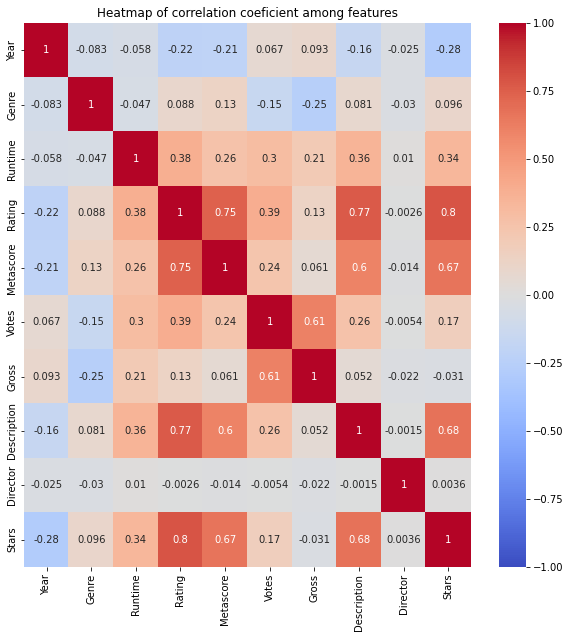

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Heatmap of correlation coeficient among features")
sns.heatmap(data.corr(),vmin = -1, vmax = 1,cmap = 'coolwarm',annot = True)
plt.show()

# Visualization

In [13]:
df = pd.read_csv('/content/drive/MyDrive/IMDB_Data/cleaned.csv',index_col=0)

In [14]:
df_=df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 0 to 6648
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         6649 non-null   object 
 1   Year         6649 non-null   int64  
 2   Genre        6649 non-null   object 
 3   Runtime      6649 non-null   int64  
 4   Rating       6649 non-null   float64
 5   Metascore    6649 non-null   float64
 6   Votes        6649 non-null   int64  
 7   Gross        6649 non-null   int64  
 8   Description  6649 non-null   object 
 9   Director     6649 non-null   object 
 10  Stars        6649 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 623.3+ KB


In [ ]:
df.sort_values(by="Rating",ascending=False).head(10)

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
1532,The Shawshank Redemption,1994,Drama,142,9.3,81.0,2693325,28340000,"Over the course of several years, two convicts...",Frank Darabont,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'..."
273,The Godfather,1972,"Crime, Drama",175,9.2,100.0,1868917,134970000,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan', '..."
92,12 Angry Men,1957,"Crime, Drama",96,9.0,96.0,795781,4360000,The jury in a New York City murder trial is fr...,Sidney Lumet,"['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam'..."
326,The Godfather: Part II,1974,"Crime, Drama",202,9.0,90.0,1277910,57300000,The early life and career of Vito Corleone in ...,Francis Ford Coppola,"['Al Pacino', 'Robert De Niro', 'Robert Duvall..."
3928,The Dark Knight,2008,"Action, Crime, Drama",152,9.0,84.0,2667150,534860000,When the menace known as the Joker wreaks havo...,Christopher Nolan,"['Christian Bale', 'Heath Ledger', 'Aaron Eckh..."
1425,Schindler's List,1993,"Biography, Drama, History",195,9.0,94.0,1362183,96900000,"In German-occupied Poland during World War II,...",Steven Spielberg,"['Liam Neeson', 'Ralph Fiennes', 'Ben Kingsley..."
2826,The Lord of the Rings: The Return of the King,2003,"Action, Adventure, Drama",201,9.0,94.0,1855474,377850000,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell..."
1533,Pulp Fiction,1994,"Crime, Drama",154,8.9,94.0,2067298,107930000,"The lives of two mob hitmen, a boxer, a gangst...",Quentin Tarantino,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja..."
180,"The Good, the Bad and the Ugly",1966,"Adventure, Western",178,8.8,90.0,765992,6100000,A bounty hunting scam joins two men in an unea...,Sergio Leone,"['Clint Eastwood', 'Eli Wallach', 'Lee Van Cle..."
4392,Inception,2010,"Action, Adventure, Sci-Fi",148,8.8,74.0,2365987,292580000,A thief who steals corporate secrets through t...,Christopher Nolan,"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ..."


In [15]:
df.describe()

,Year,Runtime,Rating,Metascore,Votes,Gross
count,6649.000000,6649.000000,6649.000000,6649.000000,6.649000e+03,6.649000e+03
mean,2001.620996,109.002406,6.578313,57.368928,1.186133e+05,4.223265e+07
std,14.231364,19.147434,0.938301,18.084680,1.933397e+05,6.729408e+07
min,1916.000000,63.000000,1.300000,1.000000,1.000800e+04,0.000000e+00
25%,1995.000000,96.000000,6.100000,45.000000,2.272400e+04,3.440000e+06
50%,2005.000000,106.000000,6.600000,58.000000,5.135800e+04,1.948000e+07
75%,2012.000000,118.000000,7.200000,71.000000,1.269640e+05,5.186000e+07
max,2021.000000,366.000000,9.300000,100.000000,2.693325e+06,9.366600e+08


In [ ]:
df.isnull().any()

Name           False
Year           False
Genre          False
Runtime        False
Rating         False
Metascore      False
Votes          False
Gross          False
Description    False
Director       False
Stars          False
dtype: bool

In [ ]:
df[['Rating']].describe()

,Rating
count,6649.000000
mean,6.578313
std,0.938301
min,1.300000
25%,6.100000
50%,6.600000
75%,7.200000
max,9.300000


In [ ]:
# plot 1 : rating
def category_rating(x):
    if x < 3:
        return "Too bad"
    if x < 5:
        return "Bad"
    if x < 7:
        return "Not bad"
    if x < 9:
        return "Good"
    return "Excellent"
dftmp=df[df['Rating'].notnull()][['Rating']]
dftmp.rating=dftmp.Rating.apply(lambda x: float(x))
dftmp['category'] = dftmp.apply(lambda x: category_rating(x.Rating), axis=1)
dftmp

<ipython-input-58-867d7a84f346>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dftmp.rating=dftmp.Rating.apply(lambda x: float(x))


,Rating,category
0,7.7,Good
1,7.9,Good
2,8.3,Good
3,8.1,Good
4,6.4,Not bad
...,...,...
6644,4.5,Bad
6645,5.4,Not bad
6646,5.9,Not bad
6647,7.8,Good


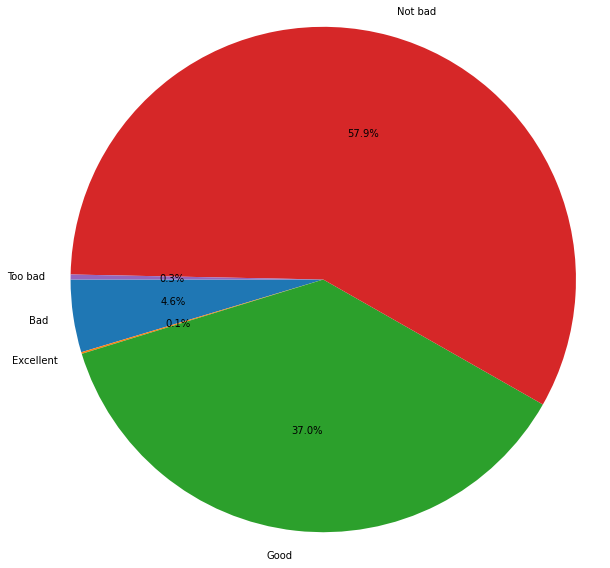

In [ ]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,10)
explode = [0.1 if i < 1000 else 0.001 for i in dftmp.groupby(['category']).count()['Rating'].tolist()]
ax1.pie(dftmp.groupby(['category']).count()['Rating'].tolist(), labels=dftmp.groupby(['category']).count().index.to_list(), autopct='%1.1f%%', startangle=180.)
ax1.axis('equal')

plt.show()

In [ ]:
# plot 2
dftmp.groupby(['Rating']).count()

,category
Rating,
1.3,1
1.5,1
1.7,1
1.9,3
2.1,1
...,...
8.8,6
8.9,1
9.0,5


In [ ]:
y = dftmp.groupby(['Rating'])['category'].count().tolist()
x = dftmp.groupby(['Rating']).count().index.to_list()

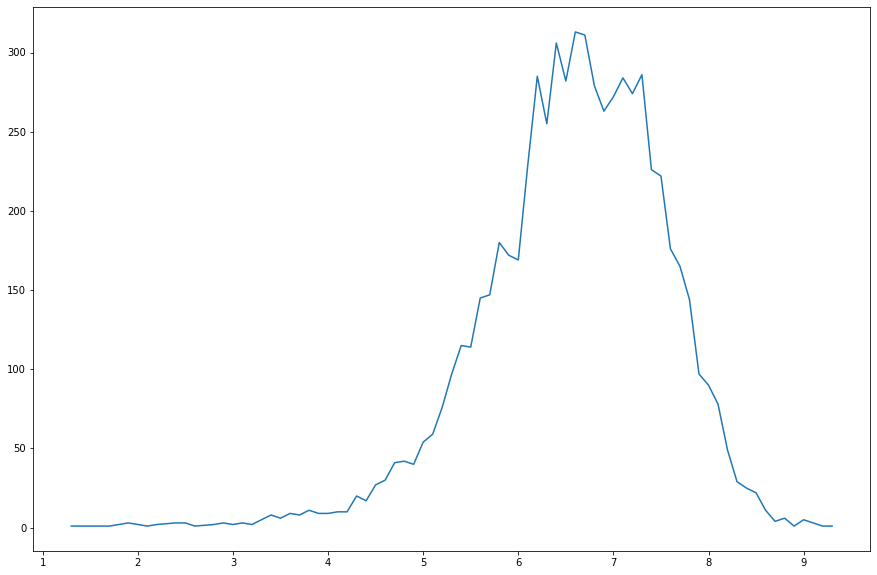

In [ ]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(15,10)
ax1.plot(x, y)
plt.show()

In [ ]:
# plot 3
dftmp= df['Year'].value_counts().reset_index().sort_values(by=['index'])

In [ ]:
y = dftmp['Year']
x = dftmp['index']

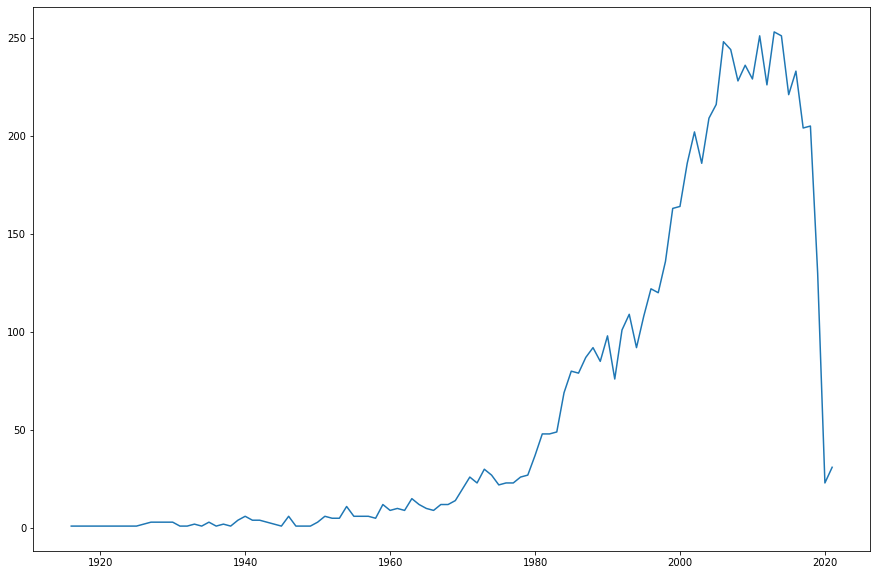

In [ ]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(15,10)
ax1.plot(x, y)
plt.show()

In [16]:
# plot 4
dftmp=df[df.Gross.notnull()][['Gross', 'Year']]
dftmp

,Gross,Year
0,2180000,1916
1,50000,1925
2,1240000,1927
3,540000,1927
4,7630000,1927
...,...,...
6644,70590000,2021
6645,44540000,2021
6646,57300000,2021
6647,34540000,2021


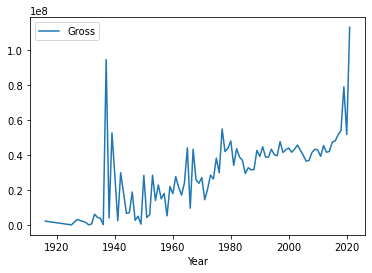

In [17]:
dftmp.groupby('Year').mean().plot(kind='line')

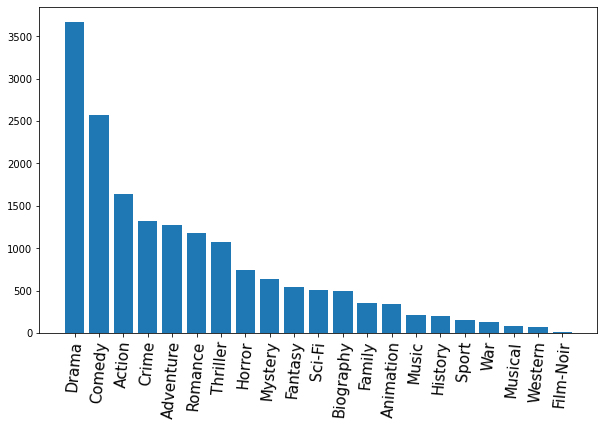

In [ ]:
#plot 5
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genre_dict.keys(),genre_dict.values(),align="center")
plt.show()

In [ ]:
#plot 6
dftmp=df_[df_.Rating.notnull()][df_.Genre.notnull()][['Rating','Genre']]
dftmp

,Rating,Genre
0,7.7,"Drama, History"
1,7.9,"Drama, History, Thriller"
2,8.3,"Drama, Sci-Fi"
3,8.1,"Drama, Romance"
4,6.4,"Drama, Music, Musical"
...,...,...
6644,4.5,"Animation, Adventure, Comedy"
6645,5.4,"Action, Crime, Horror"
6646,5.9,"Animation, Adventure, Comedy"
6647,7.8,"Animation, Action, Fantasy"


In [ ]:
genres=list(genre_dict.keys())

In [ ]:
genres_score_dict=dict()
genres_count_dict=dict()
for genre in genres:
    genres_score_dict[genre] = round(dftmp[dftmp.Genre.str.contains(genre)]['Rating'].mean(), 4)
for genre in genres:
    genres_count_dict[genre] = dftmp[dftmp.Genre.str.contains(genre)]['Rating'].count()
dftmp=pd.DataFrame(columns=["Genre", "avg. rating", "count"])
for idx, genre in enumerate(genres):
    dftmp.loc[idx] = [genre, genres_score_dict[genre], genres_count_dict[genre]]
dftmp=dftmp.sort_values(by=['avg. rating'],ascending=False)
dftmp

,Genre,avg. rating,count
20,Film-Noir,7.8846,13
17,War,7.1657,134
19,Western,7.0986,72
11,Biography,7.0945,490
15,History,7.0463,205
0,Drama,6.8662,3663
13,Animation,6.8290,338
18,Musical,6.8026,76
14,Music,6.7425,280
3,Crime,6.6432,1318


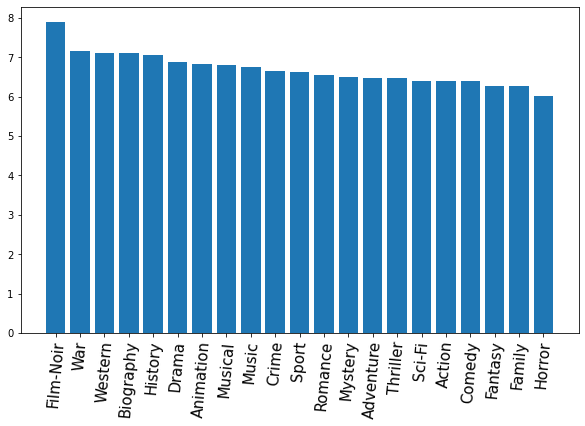

In [ ]:
x = dftmp['Genre'].to_list()
y = dftmp['avg. rating'].to_list()
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(x,y,align="center")
plt.show()

In [ ]:
#searborn

In [ ]:
df.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,"Drama, History",197,7.7,99.0,15880,2180000,The story of a poor young woman separated by p...,D.W. Griffith,"['Lillian Gish', 'Robert Harron', 'Mae Marsh',..."
1,Battleship Potemkin,1925,"Drama, History, Thriller",66,7.9,97.0,58731,50000,In the midst of the Russian Revolution of 1905...,Sergei Eisenstein,"['Aleksandr Antonov', 'Vladimir Barskiy', 'Gri..."
2,Metropolis,1927,"Drama, Sci-Fi",153,8.3,98.0,176257,1240000,In a futuristic city sharply divided between t...,Fritz Lang,"['Brigitte Helm', 'Alfred Abel', 'Gustav Fröhl..."
3,Sunrise,1927,"Drama, Romance",94,8.1,95.0,51745,540000,A sophisticated urban woman seduces a farmer i...,F.W. Murnau,"[""George O'Brien"", 'Janet Gaynor', 'Margaret L..."
4,The Jazz Singer,1927,"Drama, Music, Musical",88,6.4,66.0,10322,7630000,The son of a Jewish Cantor must defy the tradi...,Alan Crosland,"['Al Jolson', 'May McAvoy', 'Warner Oland', 'E..."


In [ ]:
rating = []
for newrate in df['Rating']:
  newrate = float(newrate)
  rating.append(newrate)
print(rating)
gross = []
for newgross in df['Gross']:
  newgross = int(newgross)
  gross.append(newgross)
print(gross)
votes = []
for newvote in df['Votes']:
  newvote = int(newvote)
  votes.append(newvote)
print(votes)

[7.7, 7.9, 8.3, 8.1, 6.4, 8.1, 7.7, 7.4, 8.5, 7.8, 7.9, 7.3, 8.1, 7.8, 7.7, 7.7, 8.5, 7.6, 7.3, 7.9, 8.1, 8.2, 8.1, 7.6, 7.5, 8.1, 8.1, 7.7, 8.0, 7.5, 8.3, 8.0, 7.2, 7.3, 8.5, 7.3, 7.2, 7.6, 8.3, 7.5, 7.5, 7.9, 8.1, 7.9, 7.0, 7.4, 7.9, 7.9, 8.2, 8.1, 8.2, 7.3, 8.2, 7.9, 7.4, 7.9, 7.7, 7.2, 8.1, 8.3, 8.0, 8.3, 7.7, 8.2, 7.3, 7.6, 7.6, 7.0, 7.8, 8.6, 8.5, 7.3, 8.1, 8.2, 7.5, 7.2, 7.5, 6.9, 7.5, 7.7, 7.4, 8.0, 7.3, 7.1, 7.6, 8.1, 7.5, 7.4, 6.7, 7.4, 6.9, 7.6, 9.0, 8.4, 8.2, 7.3, 7.2, 7.0, 8.3, 8.0, 7.9, 7.1, 7.9, 8.2, 8.3, 8.1, 8.0, 7.2, 8.0, 7.1, 7.8, 7.4, 7.5, 7.5, 7.4, 8.5, 7.7, 7.9, 8.3, 8.0, 6.5, 7.1, 7.6, 6.9, 7.6, 7.5, 8.0, 7.3, 7.2, 7.7, 7.8, 7.2, 7.0, 7.3, 8.3, 7.5, 7.2, 7.7, 8.0, 7.0, 7.8, 7.2, 8.1, 7.5, 7.4, 8.2, 7.6, 7.0, 7.0, 7.9, 8.0, 7.3, 7.1, 7.8, 7.4, 6.4, 7.8, 5.7, 7.8, 8.4, 7.7, 7.9, 7.8, 7.1, 7.4, 7.5, 7.8, 7.8, 7.8, 7.6, 8.1, 7.9, 8.2, 6.9, 7.2, 7.1, 6.7, 7.2, 7.1, 7.5, 8.8, 7.5, 7.2, 7.3, 7.8, 8.1, 7.7, 7.0, 7.4, 7.9, 8.0, 7.6, 7.7, 8.1, 7.6, 6.8, 7.5, 7.8, 7.7, 7.0,

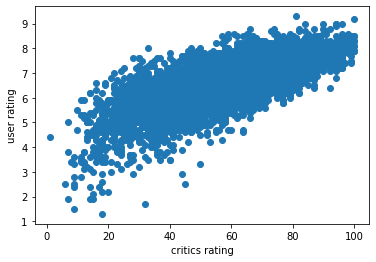

In [ ]:
meta = []
for metas in df['Metascore']:
  try:
    metas = int(metas)
    meta.append(metas)
  except:
    meta.append(0)

plt.scatter(meta, rating)
sns.set(style="whitegrid")
plt.xlabel('critics rating')
plt.ylabel('user rating')
plt.show()

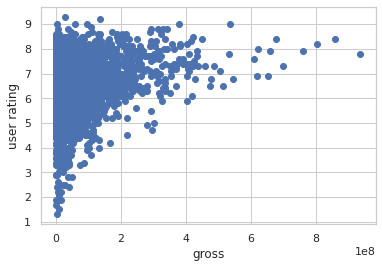

In [ ]:
plt.scatter(gross, rating)
sns.set(style="whitegrid")
plt.xlabel('gross')
plt.ylabel('user rating')

plt.show()

In [ ]:
plt.scatter(gross, meta)
sns.set(style="whitegrid")
plt.xlabel('gross')
plt.ylabel('critics rating')

plt.show()

In [ ]:
plt.scatter(votes, rating)
sns.set(style="whitegrid")
plt.xlabel('votes')
plt.ylabel('user rating')

plt.show()

# Movie Recommendation

In [ ]:
import time
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/IMDB_Data/preprocessed.csv',index_col=0)

In [ ]:
movies.head()

,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,Intolerance,1916,291,197,7.7,99.0,15880,2180000,5860.6,462,8713.00
1,Battleship Potemkin,1925,297,66,7.9,97.0,58731,50000,6332.6,2278,9031.50
2,Metropolis,1927,327,153,8.3,98.0,176257,1240000,5477.0,795,9415.25
3,Sunrise,1927,321,94,8.1,95.0,51745,540000,4119.0,734,9077.00
4,The Jazz Singer,1927,308,88,6.4,66.0,10322,7630000,3504.2,39,3364.25


In [ ]:
movies = movies.reset_index()
movies = movies.rename(columns={"index": "id"})

In [ ]:
movies.head()

,id,Name,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Description,Director,Stars
0,0,Intolerance,1916,291,197,7.7,99.0,15880,2180000,5860.6,462,8713.00
1,1,Battleship Potemkin,1925,297,66,7.9,97.0,58731,50000,6332.6,2278,9031.50
2,2,Metropolis,1927,327,153,8.3,98.0,176257,1240000,5477.0,795,9415.25
3,3,Sunrise,1927,321,94,8.1,95.0,51745,540000,4119.0,734,9077.00
4,4,The Jazz Singer,1927,308,88,6.4,66.0,10322,7630000,3504.2,39,3364.25


In [ ]:
df = movies[['Year','Genre','Runtime','Rating','Metascore','Votes','Gross','Stars','Description','Director']]

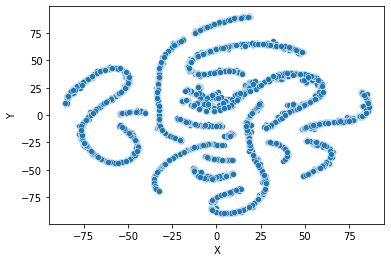

In [ ]:
tsne = TSNE(n_components=2, random_state=0)

tsne_obj = tsne.fit_transform(df)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1]})
sns.scatterplot(x="X", y="Y", data=tsne_df)

In [ ]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,Year,Genre,Runtime,Rating,Metascore,Votes,Gross,Stars,Description,Director
count,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000,6649.000000
mean,0.815438,0.484681,0.151823,0.659789,0.569383,0.040474,0.045089,0.462497,0.473933,0.517742
std,0.135537,0.289456,0.063193,0.117288,0.182674,0.072053,0.071845,0.194162,0.159300,0.291390
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.752381,0.226415,0.108911,0.600000,0.444444,0.004739,0.003673,0.334502,0.363088,0.268651
50%,0.847619,0.506739,0.141914,0.662500,0.575758,0.015410,0.020797,0.450448,0.469736,0.522231
75%,0.914286,0.716981,0.181518,0.737500,0.707071,0.043586,0.055367,0.572826,0.583048,0.778824
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


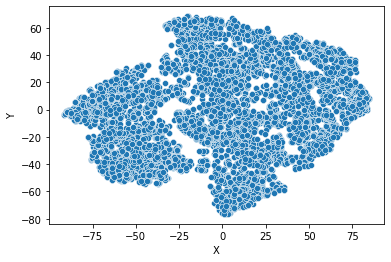

In [ ]:
tsne = TSNE(n_components=2, random_state=0)

tsne_obj = tsne.fit_transform(normalized_df)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1]})
sns.scatterplot(x="X", y="Y", data=tsne_df)

In [ ]:
normalized_df['id']=movies['id']

In [ ]:
normalized_df.T

,0,1,2,3,4,5,6,7,8,9,...,6639,6640,6641,6642,6643,6644,6645,6646,6647,6648
Year,0.000000,0.085714,0.104762,0.104762,0.104762,0.133333,0.133333,0.133333,0.142857,0.152381,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Genre,0.784367,0.800539,0.881402,0.865229,0.830189,0.905660,0.827493,0.552561,0.528302,0.808625,...,0.008086,0.018868,0.956873,0.024259,0.091644,0.369272,0.091644,0.369272,0.363881,0.223720
Runtime,0.442244,0.009901,0.297030,0.102310,0.082508,0.293729,0.135314,0.112211,0.079208,0.003300,...,0.211221,0.151815,0.161716,0.082508,0.115512,0.171617,0.132013,0.145215,0.161716,0.099010
Rating,0.800000,0.825000,0.875000,0.850000,0.637500,0.850000,0.800000,0.762500,0.900000,0.812500,...,0.662500,0.550000,0.625000,0.550000,0.587500,0.400000,0.512500,0.575000,0.812500,0.612500
Metascore,0.989899,0.969697,0.979798,0.949495,0.656566,0.909091,0.878788,0.767677,0.989899,0.797980,...,0.494949,0.373737,0.525253,0.474747,0.454545,0.353535,0.525253,0.383838,0.707071,0.424242
Votes,0.002188,0.018158,0.061957,0.015554,0.000117,0.020079,0.002018,0.001758,0.065793,0.013968,...,0.068730,0.014959,0.040532,0.013958,0.018447,0.023563,0.009479,0.003398,0.003988,0.000825
Gross,0.002327,0.000053,0.001324,0.000577,0.008146,0.003491,0.000085,0.000972,0.000021,0.000673,...,0.124901,0.014189,0.070068,0.026893,0.034847,0.075364,0.047552,0.061175,0.036876,0.043239
Stars,0.917396,0.950975,0.991434,0.955772,0.353479,0.976726,0.920401,0.807512,0.998339,0.938324,...,0.388666,0.455720,0.397786,0.185635,0.278071,0.134370,0.152267,0.233711,0.930548,0.404402
Description,0.706343,0.768503,0.655824,0.476979,0.396012,0.874151,0.599378,0.729653,0.834220,0.599747,...,0.437049,0.285887,0.261471,0.255123,0.483828,0.331560,0.251435,0.307407,0.707897,0.385661
Director,0.174077,0.858327,0.299548,0.276564,0.014695,0.583647,0.511304,0.967596,0.128485,0.936699,...,0.412208,0.247551,0.649209,0.007536,0.819894,0.601733,0.275057,0.946496,0.857573,0.980784


In [ ]:
#Brute
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(normalized_df)

end = time.time()
print(end - start)

0.0029854774475097656


In [ ]:
#KD Tree
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='kd_tree').fit(normalized_df)

end = time.time()
print(end - start)

0.01967477798461914


In [ ]:
#Ball Tree
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(normalized_df)

end = time.time()
print(end - start)

0.018711328506469727


In [ ]:
knn = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(normalized_df)

In [ ]:
# Save Model
knnPickle = open('/content/drive/MyDrive/IMDB_Data/knnpickle_file', 'wb') 
pickle.dump(knn, knnPickle)

In [ ]:
# Save Model
knnPickle = open('/content/drive/MyDrive/IMDB_Data/knnpickle_file', 'wb') 
pickle.dump(knn, knnPickle)

In [ ]:
# Load Model (if flase you)
loaded_model = pickle.load(open('/content/drive/MyDrive/IMDB_Data/knnpickle_file', 'rb'))

In [ ]:
df.reset_index(inplace=True)

In [ ]:
def recommend(name):
  avgRating = 0
  new_movie = movies[movies['Name'].str.contains(x)].iloc[0].to_frame().T
  index_ = new_movie['id'].tolist()
  index = index_[0]

  distances, indices = loaded_model.kneighbors(normalized_df.iloc[index,:].values.reshape(1, -1), n_neighbors = 6)
  print('\nRecommended Movies: \n')
  for i in range(1,len(indices[0])):
    print(i, ". Name: " , movies.iloc[indices[0][i]].Name , "| Rating:" , movies.iloc[indices[0][i]].Rating,"| Distance;",distances[0][i])
    avgRating = avgRating + movies.iloc[indices[0][i]].Rating
  
  avgRating = avgRating/(len(indices[0])-1)
  print('\nThe predicted rating for %s is: %f' %(x,avgRating))
  print('The actual rating for %s is %f\n' %(x,movies.iloc[index].Rating ))


In [ ]:
import warnings
warnings.filterwarnings("ignore")
x = input('Enter a movie title: ')
recommend(x)

Enter a movie title: Toy Story

Recommended Movies: 

1 . Name:  Toy Story 2 | Rating: 7.9 | Distance; 0.258070447191392
2 . Name:  The Terminator | Rating: 8.1 | Distance; 0.3252382685555357
3 . Name:  Juno | Rating: 7.5 | Distance; 0.33372518367675336
4 . Name:  Borat | Rating: 7.3 | Distance; 0.3338834361746436
5 . Name:  Toy Story 3 | Rating: 8.3 | Distance; 0.33708500871018976

The predicted rating for Toy Story is: 7.820000
The actual rating for Toy Story is 8.300000



In [ ]:
#Evaluate
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")


def recommend_id(index):
  avgRating = 0
  distances, indices = loaded_model.kneighbors(normalized_df.iloc[index,:].values.reshape(1, -1), n_neighbors = 6)
  for i in range(1,len(indices[0])):
    avgRating = avgRating + movies.iloc[indices[0][i]].Rating
  avgRating = avgRating/(len(indices[0])-1)
  return(avgRating)
a = []
b = []
for i in range(0,6000):
  a.append(recommend_id(i))
  b.append(movies.iloc[i].Rating)
mae = mean_absolute_error(a, b)
print("Mean Absolute Error:", mae)

MSE = mean_squared_error(a, b)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:", mae)

Mean Absolute Error: 0.20759
Root Mean Square Error: 0.20759
